In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from fastai2.vision.all import *
import PIL

In [ ]:
to_tensor = lambda img: TTF.to_tensor(img)
to_img    = lambda tensor: TTF.to_pil_image(tensor)
size      = (270,150)
hstack    = lambda img1,img2: PIL.Image.fromarray(np.hstack((array(img1), array(img2))))

fname = '../assets/imgs/atomic-blonde.jpg'
img   = PIL.Image.open(fname).resize(size)

In [ ]:
#export
import PIL
import kornia as K
import torchvision.transforms.functional as TTF
from PIL import Image

class KorniaWrapper(RandTransform):
    '''
    Pass in a kornia function, module, list of modules, or nn.Sequential
    containers to `kornia_tfm`.
    If passing functions, you can pass in function arguments as keyword
    args (**kwargs), which can also be random number generators.
    
    Example
    =======
    * KorniaWrapper(kornia.adjust_hue, hue_factor=1.2)
    * KorniaWrapper(kornia.adjust_hue, hue_factor=np.random.random)
    * KorniaWrapper(kornia.adjust_hue, hue_factor=partial(np.random.uniform, low=1.1, high=1.5))
    * KorniaWrapper(kornia.augmentation.ColorJitter(.2,.3,.1,.2))
    * KorniaWrapper(kornia.augmentation.ColorJitter, brightness=.2, contrast=.3)
    * KorniaWrapper(nn.Sequential(*[kornia.augmentation.ColorJitter()]))
    * KorniaWrapper([
        kornia.augmentation.ColorJitter(.2),
        kornia.augmentation.RandomMotionBlur(3, 5., 1.)
    ]))
    '''
    order = 10
    def __init__(self, kornia_tfm=None,p=1., **kwargs):
        super().__init__(p=p)
        self.tfm = kornia_tfm
        self.input_kwargs = kwargs
        self.call_kwargs  = dict.fromkeys(kwargs)
        self._pipe = Pipeline([ToTensor(), IntToFloatTensor()])
        self.process_tfm()
    
    def before_call(self, b, split_idx, verbose=False):
        'Compute `p` of applying transform, process input kwargs if applicable'
        self.do = self.p==1. or random.random() < self.p
        for arg,value in self.input_kwargs.items():
            if hasattr(value, '__call__'): self.call_kwargs[arg] = value()
            else: self.call_kwargs[arg] = value
    
    def process_tfm(self):
        'Process the input `kornia_tfm` argument and make it callable'
        if hasattr(self.tfm, 'forward') and hasattr(self.tfm, '__iter__'):
            pass                                ## -- nn.Sequential

        elif hasattr(self.tfm, 'forward') and type(self.tfm) is not type:      
            self.tfm = nn.Sequential(self.tfm)  ## -- Kornia module (called)
        
        elif hasattr(self.tfm, 'forward') and type(self.tfm) is type:      
            #self.tfm = nn.Sequential(self.tfm)  ## -- Kornia module (uncalled)
            pass
        
        elif isinstance(self.tfm, list):
            self.tfm = nn.Sequential(*self.tfm) ## -- list of Kornia Modules
    
    def _encode(self, o:TensorImage): return TensorImage(self.tfm(o, **self.call_kwargs)) if self.do else o
    def encodes(self, o:torch.Tensor): return self._encode(o)
    def encodes(self, o:Image.Image):  return self._encode(self._pipe(PILImage(o)))
    def encodes(self, o:TensorImage):  return self._encode(o)
    def encodes(self, o:PILImage):     return self._encode(self._pipe(o))
    def encodes(self, o:(str,Path)):   return self._encode(self._pipe(PILImage.create(o)))
    def encodes(self, o:(TensorCategory,TensorMultiCategory)): return o
    
    def __repr__(self): return self.tfm.__repr__()

In [ ]:
from nbdev.showdoc import *

In [ ]:
show_doc(KorniaWrapper)

<h2 id="KorniaWrapper" class="doc_header"><code>class</code> <code>KorniaWrapper</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>KorniaWrapper</code>(**`kornia_tfm`**=*`None`*, **`p`**=*`1.0`*, **\*\*`kwargs`**) :: `RandTransform`

```
Pass in a kornia function, module, list of modules, or nn.Sequential
containers to `kornia_tfm`.
If passing functions, you can pass in function arguments as keyword
args (**kwargs), which can also be random number generators.

Example
=======
* KorniaWrapper(kornia.adjust_hue, hue_factor=1.2)
* KorniaWrapper(kornia.adjust_hue, hue_factor=np.random.random)
* KorniaWrapper(kornia.adjust_hue, hue_factor=partial(np.random.uniform, low=1.1, high=1.5))
* KorniaWrapper(kornia.augmentation.ColorJitter(.2,.3,.1,.2))
* KorniaWrapper(kornia.augmentation.ColorJitter, brightness=.2, contrast=.3)
* KorniaWrapper(nn.Sequential(*[kornia.augmentation.ColorJitter()]))
* KorniaWrapper([
    kornia.augmentation.ColorJitter(.2),
    kornia.augmentation.RandomMotionBlur(3, 5., 1.)
]))
```

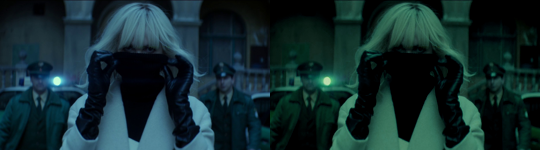

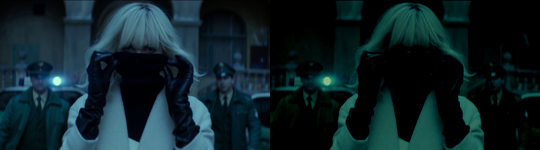

In [ ]:
tfm = KorniaWrapper(K.augmentation.ColorJitter(0.2,0.3,0.1,0.2))
hstack(img, to_img(tfm(img, split_idx=0)[0]))
hstack(img, to_img(tfm(img, split_idx=0)[0]))

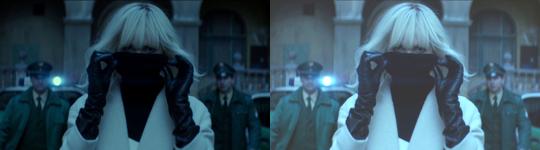

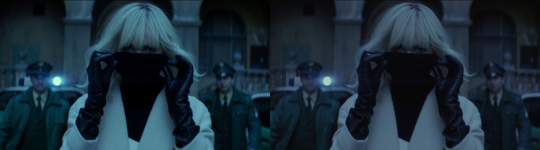

In [ ]:
tfm = KorniaWrapper(nn.Sequential(K.augmentation.ColorJitter(.2,.3,.2,.1)))
hstack(img, to_img(tfm(img, split_idx=0)[0]))
hstack(img, to_img(tfm(img, split_idx=0)[0]))

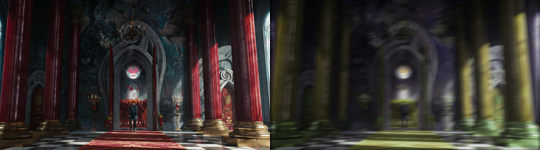

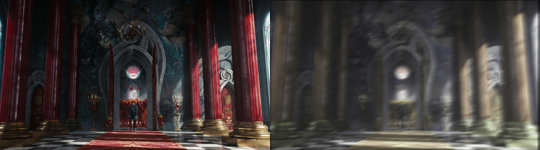

In [ ]:
img = PIL.Image.open('../assets/imgs/alice-in-wonderland.jpg').resize(size)
tfm = KorniaWrapper([
    K.augmentation.ColorJitter(brightness=.1,
                               contrast=0,
                               saturation=(.1,.9),
                               hue=.2),
    K.augmentation.RandomMotionBlur(kernel_size = (7,7),
                                    angle       = (5., 15.),
                                    direction   = (-1., 1.))
])
hstack(img, to_img(tfm(img, split_idx=0)[0]))
hstack(img, to_img(tfm(img, split_idx=0)[0]))

In [ ]:
import random
def spaced_num_generator(low:int, high:int):
    '''
    If low and high are both odd numbers, generate odd numbers
    between the two, and vice versa
    '''
    return partial(random.randrange, start=low, stop=high, step=2)

def spaced_tuple_generator(low:int, high:int):
    return (spaced_num_generator(low,high), spaced_num_generator(low,high))

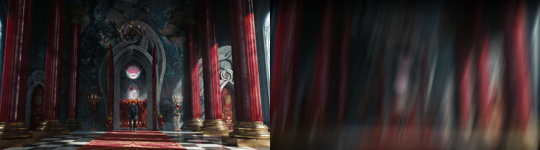

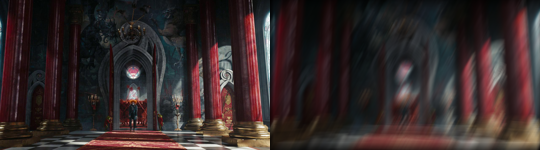

In [ ]:
tfm = KorniaWrapper(K.filters.motion_blur,
                    kernel_size = spaced_num_generator(5,55),
                    angle=partial(np.random.uniform, low=55., high=90.),
                    direction=partial(np.random.uniform, low=-1., high=1.),
                    p=1.)
hstack(img, to_img(tfm(to_tensor(img).unsqueeze(0), split_idx=0)[0]))
hstack(img, to_img(tfm(to_tensor(img).unsqueeze(0), split_idx=0)[0]))

In [ ]:
to_tensor(img).shape
to_tensor(img).unsqueeze(0).shape

torch.Size([3, 150, 270])

torch.Size([1, 3, 150, 270])

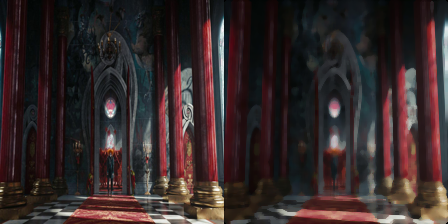

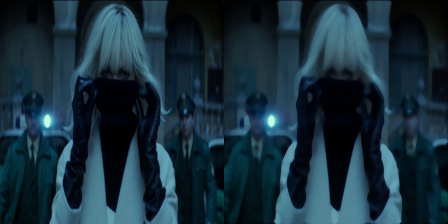

In [ ]:
tfm = KorniaWrapper(K.filters.MedianBlur(kernel_size=(5,5)))
#tfm = KorniaWrapper(K.filters.MedianBlur(kernel_size=(5,5)), p=1.0)

size=(224,224)

img = PIL.Image.open('../assets/imgs/alice-in-wonderland.jpg').resize(size)
hstack(img, to_img(tfm(to_tensor(img).unsqueeze(0), split_idx=0)[0]))

img = Image.open('../assets/imgs/atomic-blonde.jpg').resize(size)
hstack(img, to_img(tfm(to_tensor(img).unsqueeze(0), split_idx=0)[0]))

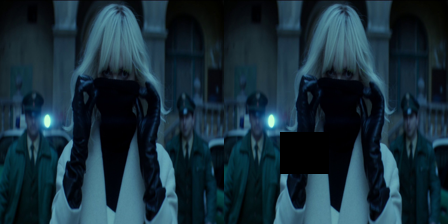

In [ ]:
tfm = KorniaWrapper([
    K.augmentation.RandomErasing(p=1.0,
                                 scale=(0.02, 0.1),
                                 ratio=(0.30, 15.))
], p=1.0)

hstack(img, to_img(tfm(to_tensor(img).unsqueeze(0), split_idx=0)[0]))

### Combine Transforms With FastAI `DataLoader`

In [ ]:
Grayscale   = KorniaWrapper(K.augmentation.RandomGrayscale(p=1.0), p=0.3)
StyleTfm    = KorniaWrapper(K.filters.MedianBlur(kernel_size=(5,5)), p=0.2)
ColorJitter = KorniaWrapper(
    K.augmentation.ColorJitter(brightness=.1,
                               contrast=0,
                               saturation=(.1,.9),
                               hue=.2),
    p=0.6)

MotionBlur  = KorniaWrapper(
    K.augmentation.RandomMotionBlur(kernel_size = (7,7),
                                    angle       = (5., 15.),
                                    direction   = (-1., 1.)),
    p=0.4)

# Grayscale   = KorniaWrapper(K.augmentation.RandomGrayscale(p=1.0),   p=1.)
# StyleTfm    = KorniaWrapper(K.filters.MedianBlur(kernel_size=(5,5)), p=1.)
# ColorJitter = KorniaWrapper(
#     K.augmentation.ColorJitter(brightness=.1,
#                                contrast=0,
#                                saturation=(.1,.9),
#                                hue=.2),
#     p=1.)

# MotionBlur  = KorniaWrapper(
#     K.augmentation.RandomMotionBlur(kernel_size = (7,7),
#                                     angle       = (5., 15.),
#                                     direction   = (-1., 1.)),
#     p=1.)

In [ ]:
pipe = Pipeline(funcs=[ColorJitter, MotionBlur, Grayscale, StyleTfm], split_idx=0)

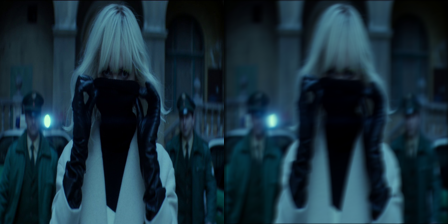

In [ ]:
hstack(img, to_img(pipe(to_tensor(img).unsqueeze(0))[0]))

In [ ]:
dblock = DataBlock(
    blocks     = (ImageBlock, CategoryBlock),
    get_items  = get_image_files,
    get_x      = Pipeline([PILImage.create]),
    get_y      = parent_label,
    splitter   = RandomSplitter(seed=42, valid_pct=0.),
    item_tfms  = [Resize(size=(400,400), method=ResizeMethod.Squish, pad_mode=PadMode.Zeros)],
    #batch_tfms = [Grayscale, StyleTfm, ColorJitter, MotionBlur, Normalize.from_stats(*imagenet_stats)]
    batch_tfms = Pipeline([Grayscale,ColorJitter,ColorJitter,MotionBlur,Normalize.from_stats(*imagenet_stats)])
    #batch_tfms = [ColorJitter, MotionBlur, Grayscale, StyleTfm, Normalize.from_stats(*imagenet_stats)]
    #batch_tfms = [Grayscale]
)

In [ ]:
Pipeline([ColorJitter, MotionBlur, Grayscale, StyleTfm, Normalize.from_stats(*imagenet_stats)])

Pipeline: KorniaWrapper -> KorniaWrapper -> KorniaWrapper -> KorniaWrapper -> Normalize

In [ ]:
dls = dblock.dataloaders('/Users/rahulsomani/Desktop/shot-type/train', bs=3)

TypeError: '<' not supported between instances of 'L' and 'int'

In [ ]:
dblock.summary??

In [ ]:
dblock.summary('/Users/rahulsomani/Desktop/shot-type/train')

Setting-up type transforms pipelines
Found 10747 items
2 datasets of sizes 10747,0
Setting up Pipeline: PILBase.create -> PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create -> PILBase.create
    starting from
      /Users/rahulsomani/Desktop/shot-type/train/shot-type-group/conformist__the__1970__017_cropped.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=610x369
    applying PILBase.create gives
      PILImage mode=RGB size=610x369
  Pipeline: parent_label -> Categorize
    starting from
      /Users/rahulsomani/Desktop/shot-type/train/shot-type-group/conformist__the__1970__017_cropped.jpg
    applying parent_label gives
      shot-type-group
    applying Categorize gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=610x369, TensorCategory(1))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> Korni

In [ ]:
pipe = Pipeline(funcs=[ColorJitter, MotionBlur, Grayscale, StyleTfm, Normalize.from_stats(*imagenet_stats)], split_idx=0)
dls.after_batch = pipe

In [ ]:
dblock.dataloaders??

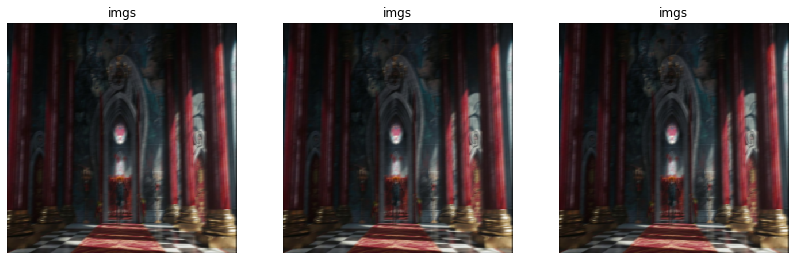

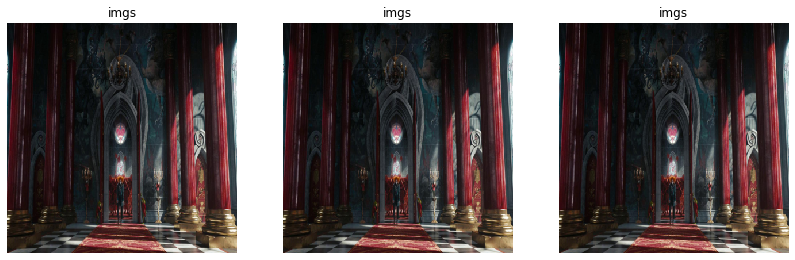

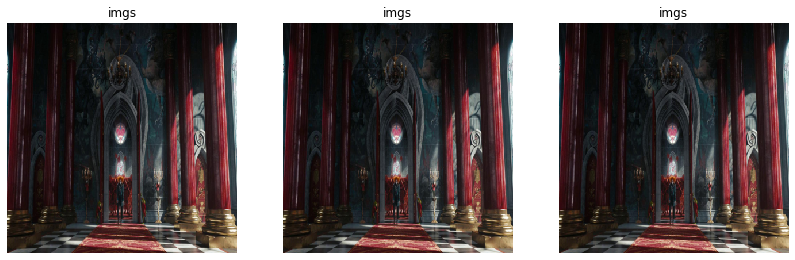

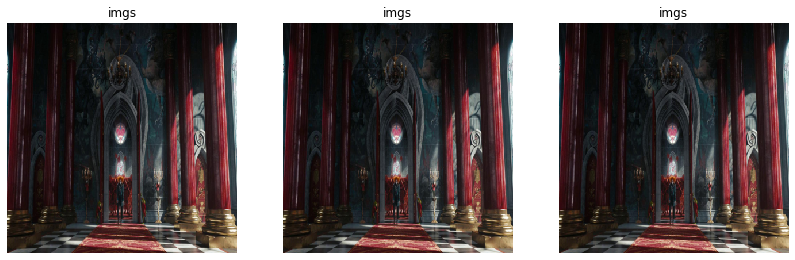

In [ ]:
dls = dblock.dataloaders('../assets/imgs/', bs=3)
dls.show_batch(figsize=(14,14), unique=True)
dls.show_batch(figsize=(14,14), unique=True)
dls.show_batch(figsize=(14,14), unique=True)
dls.show_batch(figsize=(14,14), unique=True)

### TODO

Kornia doesn't have the ability (?) to randomise the `kernel_size` of transformations before calling them. With `KorniaWrapper`, you can pass in `kernel_size` as a keyword argument with a pre-defined `spaced_tuple_generator` to produce a different kernel size before each call.

I don't get why this doesn't work. `kernel_size` expects a tuple of ints...

In [ ]:
def spaced_tuple_generator(low:int, high:int):
    return spaced_num_generator(low,high)(), spaced_num_generator(low,high)()

spaced_tuple_generator(low=3, high=11)

(7, 3)

In [ ]:
img = PIL.Image.open('../assets/imgs/atomic-blonde.jpg').resize(size)
img2batch = lambda img: to_tensor(img).unsqueeze(0)

tfm = KorniaWrapper(K.filters.MedianBlur, p=1.0,
                    kernel_size = partial(spaced_tuple_generator, low=3, high=11))
tfm(None,None)
# hstack(img, to_img(tfm(img2batch(img), split_idx=0)[0]))
# hstack(img, to_img(tfm(img2batch(img), split_idx=0)[0]))
# hstack(img, to_img(tfm(img2batch(img), split_idx=0)[0]))
# hstack(img, to_img(tfm(img2batch(img), split_idx=0)[0]))

In [ ]:
tfm.call_kwargs

{'kernel_size': (5, 7)}

In [ ]:
tfm.tfm(**tfm.call_kwargs)

MedianBlur()

In [ ]:
tfm(img2batch(img), split_idx=0)

TypeError: __init__() got multiple values for argument 'kernel_size'